## Some basic image preprocessing with `numpy`

In [1]:
import numpy as np
import imageio as io
from matplotlib import pyplot as plt

img = io.imread('data/440px-Litoria_infrafrenata_-_Julatten.jpg')

In [2]:
def get_axes():
    return plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(6,4))

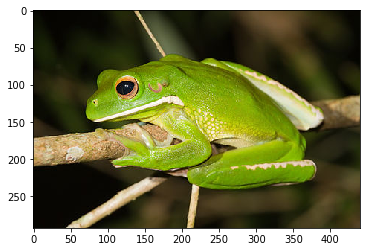

In [3]:
fig, axs = get_axes()
_ = axs.imshow(img)

### Greyscale

In [4]:
def greyscale(img, quantise=True, 
              coeff={'r': 0.2126, 'g': 0.7152, 'b': 0.0722}):
    
    img = (coeff['r'] * img[:,:,0] + 
           coeff['g'] * img[:,:,1] + 
           coeff['b'] * img[:,:,2])
    
    return img.astype(np.int16)

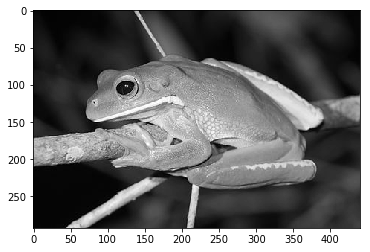

In [5]:
fig, axs = get_axes()
_ = axs.imshow(greyscale(img),cmap='gray')

### Whitening

In [6]:
def whiten(img):
    img_mu  = np.mean(img)
    img_std =np.std(img)
    return (img - img_mu) / img_std

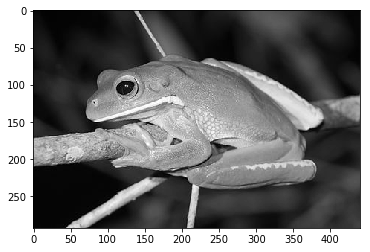

In [7]:
fig, axs = get_axes()
_ = axs.imshow(whiten(greyscale(img)), cmap='gray')

### Histogram equalisation

In [8]:
def histogram(img):
    grey_img = greyscale(img)
    a = grey_img == (np.arange(255).reshape(-1,1) * 
                     np.ones(np.product(grey_img.shape)*255)
                     .reshape(255,-1)).reshape(255,*grey_img.shape)
    return np.cumsum(np.sum(a.reshape(255,-1),axis=1)) / np.sum(a)

def equalise(img):
    hist = histogram(img)
    hist_eq = lambda i: np.int16(hist[i]*255)
    return np.vectorize(hist_eq)(greyscale(img))

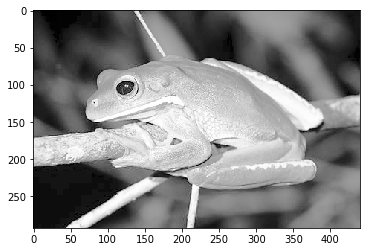

In [9]:
fig, axs = get_axes()
_ = axs.imshow(equalise(img), cmap='gray')

### Convolution

In [10]:
def pad(x, value=0, padding=1):
    x_padded  = value * np.ones(np.array(x.shape) + padding*2)
    x_padded[padding:-padding,padding:-padding] = x
    return x_padded

def convolve_prep(x, k=3):
    shape = [*x.shape,k,k]
    x_padded = pad(x, padding=(k-1)//2)
    stride_elem = x_padded.strides[1]
    stride_row  = x_padded.shape[0] * stride_elem
    A = np.lib.stride_tricks.as_strided(x_padded,shape=shape,
                                        strides=(stride_elem, stride_row, 
                                                 stride_row, stride_elem))
    return np.swapaxes(A, 0, 1)

def convolve(X, fn=np.mean, k=3):
    padded_X = convolve_prep(X, k=k)
    A = np.apply_along_axis(fn, 1, padded_X.reshape(-1,k*k))
    return A.reshape(X.shape)

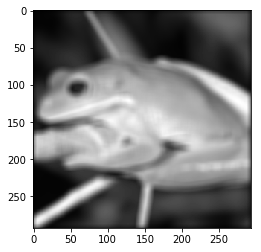

In [11]:
img_whitened = greyscale(img[:293,65:358])

fig, axs = get_axes()
_ = axs.imshow(convolve(img_whitened, k=11), cmap='gray')

#### Convolution: Gaussian blur

In [12]:
def gaussian_blur(img, k, sigma):
    kernel_grid = lambda k: np.abs(np.array([((i)//k, (i)%k) for i in range(k*k)])
                      .reshape(k*k,2) - (k//2,k//2))

    pixel_weight = lambda k: np.sum(kernel_grid(k).T**2, axis=0)

    gaussian = lambda w, sigma: np.exp(-(w)/(2*sigma**2))/(2*np.pi*sigma**2)

    gaussian_blur = lambda pixels: np.dot(gaussian(pixel_weight(k), sigma), pixels)

    return convolve(img, fn=gaussian_blur, k=k)

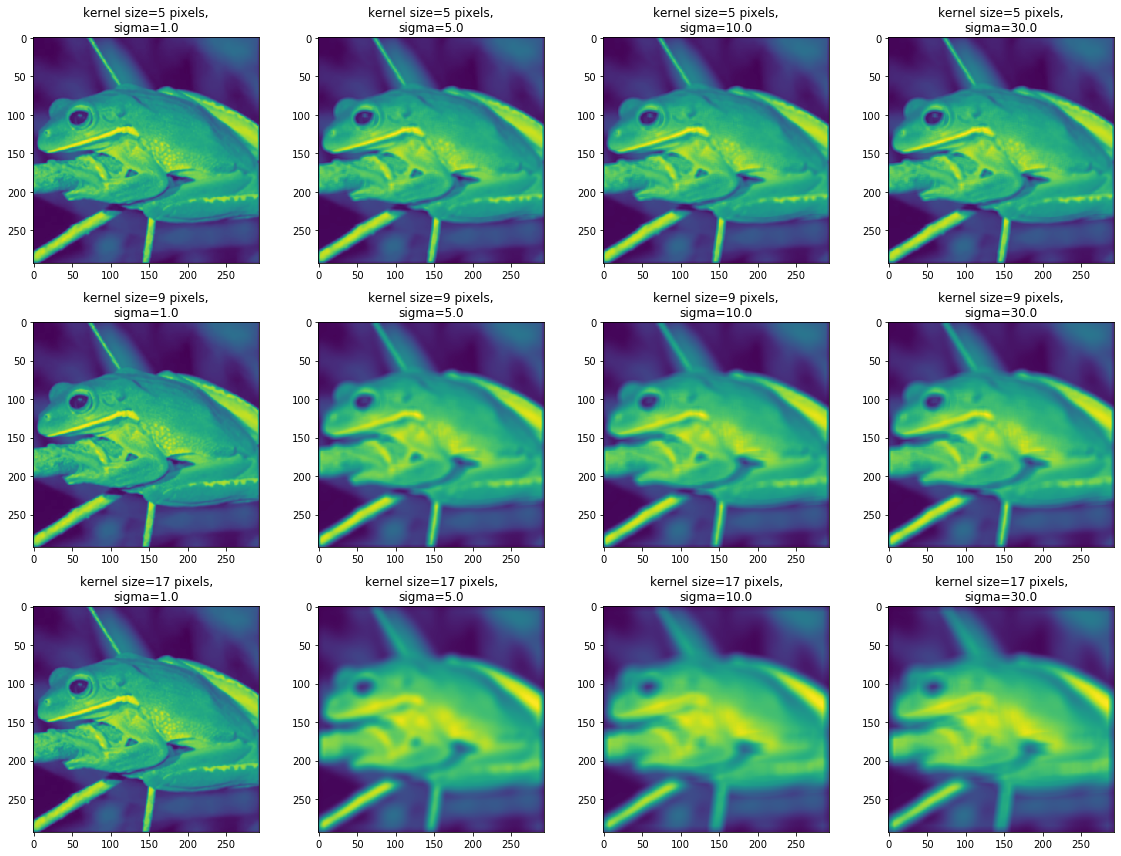

In [13]:
img_whitened = greyscale(img[:293,65:358])

ks     = [5, 9, 17]
sigmas = [1, 5, 10, 30]

nrows, ncols = len(ks), len(sigmas)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4,nrows*4))
for i,(k,sigma) in enumerate([(k,s) for k in ks for s in sigmas]):
    r, c = i // ncols, i % ncols
    axs[r][c].imshow(gaussian_blur(img_whitened, k, sigma))
    axs[r][c].set_title('kernel size={0} pixels,\nsigma={1:.1f}'.format(k, sigma))
plt.tight_layout()

#### Convolution: Edge filters

In [12]:
img_eq = equalise(img[:293,65:358])

edge_filter = lambda img,f: np.sum(np.multiply(convolve_prep(img, k=3), f), axis=(-2,-1))

##### Prewitt

In [13]:
prewitt = np.vstack([[1,0,-1]]*3)

Text(0.5,1,'Prewitt, vertical')

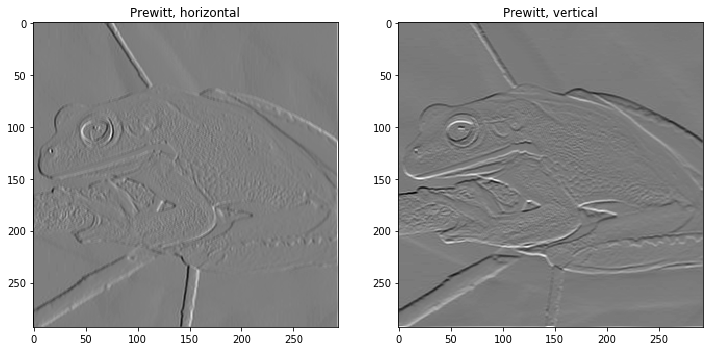

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].imshow(edge_filter(img_eq, prewitt), cmap='gray')
axs[0].set_title('Prewitt, horizontal')
axs[1].imshow(edge_filter(img_eq, prewitt.T), cmap='gray')
axs[1].set_title('Prewitt, vertical')

##### Sobel

In [15]:
sobel   = np.vstack([[1, 0, -1],
                     [2, 0, -2],
                     [1, 0, -1]])

Text(0.5,1,'Sobel, vertical')

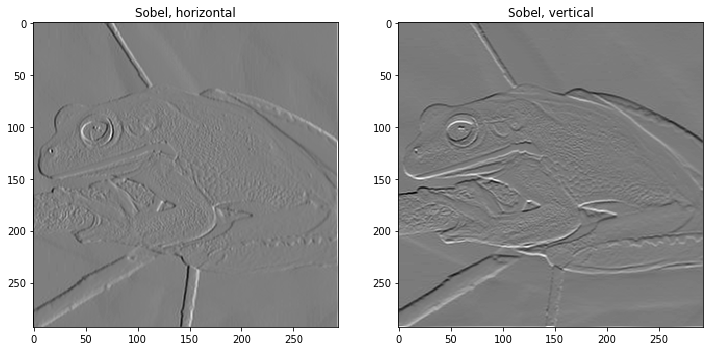

In [16]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axs[0].imshow(edge_filter(img_eq, sobel), cmap='gray')
axs[0].set_title('Sobel, horizontal')
axs[1].imshow(edge_filter(img_eq, sobel.T), cmap='gray')
axs[1].set_title('Sobel, vertical')

##### Laplacian

In [17]:
laplacian = np.vstack([[0, -1, 0],
                       [-1, 4,-1],
                       [0, -1, 0]])

Text(0.5,1,'Laplacian')

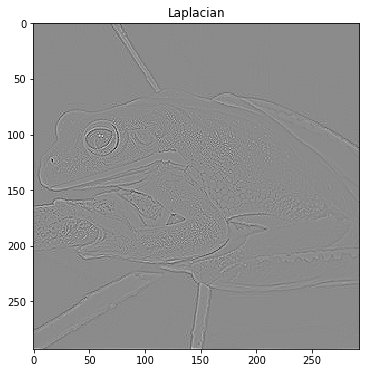

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
axs.imshow(edge_filter(img_eq, laplacian), cmap='gray')
axs.set_title('Laplacian')